In [5]:
import utils        #need to import functions to use them 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import xlwings as xw

In [ ]:
#Preparing for presentation 
file_name = 'data/files naive/sle_1_is_naive.csv'
df = pd.read_csv(file_name)
df = utils.remove_rows(df, 'productive', True)
combined_df = utils.make_combined_rows(df, ['IGH', 'IGK', 'IGL'])
gene_counts_df = utils.get_gene_counts_df(df, ['v_gene', 'j_gene', 'd_gene'])
trim_df = utils.remove_by_threshold(df, gene_counts_df, 0.05)
utils.amino_acid_count(trim_df, 'R') 
utils.crd3_pKa(trim_df)
print(trim_df)

KeyError: "None of [Index(['IGK_v_gene', 'IGK_d_gene', 'IGK_j_gene', 'IGL_v_gene', 'IGL_d_gene',\n       'IGL_j_gene'],\n      dtype='object')] are in the [columns]"

YOU NEED TO TRY USING https://docs.xlwings.org/en/stable/matplotlib.html MIGHT BE GAME CHANGING!!!!!

<Axes: ylabel='IGK_v_gene'>

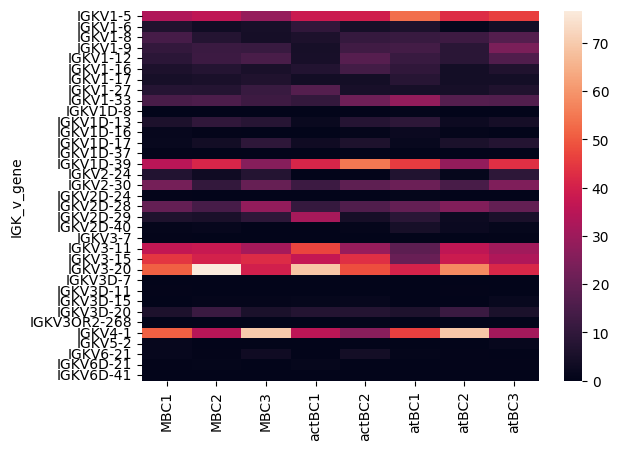

In [4]:
#HEATMAP! NEED FREQUENCY NOT COUNT!
file_name = 'data/Atypical_heavy_light_chains.csv'
df = pd.read_csv(file_name)
df = utils.remove_rows(df, 'productive', True)
# utils.amino_acid_count(df, 'R') #TECHINCALLY DONT NEED TO INCLUDE FOR THIS ONE
# utils.crd3_pKa(df)
all_igh, all_iglk = utils.all_heavyLight_genes([df], ['v_gene'])
all_igl = [gene for gene in all_iglk if gene.startswith("IGL")]
all_igk = [gene for gene in all_iglk if gene.startswith("IGK")]
all_igk.sort()
ksample_df = df[['Sample', 'Celltype (Cluster)', 'IGK_v_gene']].copy().dropna(subset=['IGK_v_gene'])
data = {}
needed_cells = ["MBC1", "MBC2", "MBC3", "actBC1", "actBC2", "atBC1", "atBC2", "atBC3"]
s_types = []
for sample, sample_info in ksample_df.groupby("Sample"):
    samp = {}
    for cell_name, cell_info in sample_info.groupby("Celltype (Cluster)"):
        if cell_name not in needed_cells: continue
        counts = cell_info.value_counts("IGK_v_gene")
        samp[cell_name] = (counts/counts.sum()) * 100 #maybe do log2 instead?
    samp_df = pd.DataFrame.from_dict(samp).fillna(0)
    data[sample] = samp_df
combined = reduce(lambda a, b: a.add(b, fill_value=0), data.values())
new_df = pd.DataFrame.from_dict(combined).reset_index()
new_df['Prefix'] = new_df['IGK_v_gene'].str[:6]
new_df['sortNum'] = new_df['IGK_v_gene'].apply(utils.get_gene_num)
new_df = new_df.sort_values(by=['Prefix', 'sortNum']).drop(columns=['Prefix', 'sortNum']).set_index("IGK_v_gene")
# plt.figure(figsize=(10, 6))
ax = sns.heatmap(new_df, yticklabels=True, annot=False) 
ax
#plt.show()
# plot_path = os.path.abspath("heatmap.png")
# plt.savefig(plot_path, bbox_inches='tight')
# plt.close()
# sheet = xw.Book().sheets[0]
# print("Image saved to:", plot_path)
# print("Exists?", os.path.exists(plot_path))
# sheet.pictures.add(plot_path, name="rwar", update=True)
# os.remove(plot_path)

In [9]:
file_name = 'Atypical_heavy_light_chains.csv'
df = pd.read_csv(file_name)
df = utils.remove_rows(df, 'productive', True)
utils.amino_acid_count(df, 'R')
utils.crd3_pKa(df)
gene_counts_df = utils.get_gene_counts_df(df, ['v_gene', 'j_gene', 'd_gene'])
trim_df = utils.remove_by_threshold(df, gene_counts_df, 0.05)
hype_info = []
all_igh, all_iglk = utils.all_heavyLight_genes([trim_df], ['v_gene', 'j_gene', 'd_gene'])
for cell_type, cell_info in trim_df.groupby("Celltype (Cluster)"):
    pair_df = utils.get_pair_counts(cell_info, ['v_gene', 'j_gene', 'd_gene'])
    cur_counts_df = utils.get_gene_counts_df(cell_info, ['v_gene', 'j_gene', 'd_gene'])
    cur_all_igh, cur_all_iglk = utils.all_heavyLight_genes([cell_info], ['v_gene', 'j_gene', 'd_gene'])
    #GAH WHICH ONES TO USE?! do i make sure to just use the current ones for the test and then add in blanks and reorder so everything overlaps nicely?? ASK PETER!
    output_df = utils.get_hypergoemetric_test(pair_df, cur_counts_df, cur_all_igh, cur_all_iglk)
    hype_info.append([cell_type, output_df])
    #hype_info.append(output_df)
print(hype_info)

The following light chain genes were removed: ['IGKV2D-30', 'IGKV3D-7', 'IGKV3OR2-268', 'IGKV6D-41', 'IGLV3-12', 'IGLV5-52', 'IGLV2-8', 'IGLJ6']
[['MBC1',            IGKL           IGH  observed  expected     p_val  adj_pvals
0     IGKV1D-39      IGHD6-13         2  0.628571  0.130314   0.364673
1     IGKV1D-39      IGHD5-24         1  0.363393  0.306448   0.733450
2     IGKV1D-39  IGHD2OR15-2B         1  0.265179  0.234234   0.584755
3     IGKV1D-39      IGHV1-18         3  0.481250  0.012182   0.061008
4     IGKV1D-39    IGHV1-69-2         3  0.608929  0.022834   0.099670
...         ...           ...       ...       ...       ...        ...
4923    IGKV1-6      IGHD1-20         1  0.011161  0.011110   0.056936
4924    IGKV1-6      IGHD3-16         2  0.109375  0.005033   0.031434
4925    IGKV1-6       IGHV6-1         0  0.014509  1.000000   1.000000
4926    IGKV1-6      IGHV1-69         0  0.010045  1.000000   1.000000
4927    IGKV1-6       IGHD2-8         0  0.034598  1.000000   1.

In [4]:
all_igh, all_iglk = utils.all_heavyLight_genes([trim_df], ['v_gene', 'j_gene', 'd_gene'])
needed_Lgenes = [gene for gene in all_iglk if gene.startswith("IGLV") or gene.startswith("IGKV")]
needed_Lgenes.sort()
trim_totals = []
for cell_type, cell_info in trim_df.groupby("Celltype (Cluster)"):
    cell_df = utils.lightChain_vs_heavyRcount_relFrequency(cell_info, needed_Lgenes, "cdr_R_count")
    trim_totals.append([cell_type, cell_df])

Organizing data from native files. Want to make graphs showing the relative frequenices of heavy chains with 0 Rs and with more the 0 Rs for each light chain (for each paitent: 3 hcd and 3 sle). 

In [2]:
directory = r"C:\Users\tskal\OneDrive\Desktop\Working for Mama!\files naive"
file_names = []
fkeys = []
for path, folders, files in os.walk(directory):
    for filename in files: 
        full_name = "files naive/"+filename
        fkey = filename[:3]+filename[4]
        file_names.append(full_name)
        fkeys.append(fkey)
dfs = []
for f in file_names:
    dfs.append(pd.read_csv(f))
all_igh, all_iglk = utils.all_heavyLight_genes(dfs, ['v_gene', 'j_gene', 'd_gene'])

In [3]:
needed_genes = [gene for gene in all_iglk if gene.startswith("IGLV") or gene.startswith("IGKV")]
needed_genes.sort()

In [ ]:
count = 0
needed_info = []
trimed_dfs = []
for cur_df in dfs: 
    #removing rows that are not productive or Naive 
    cur_df = utils.remove_rows(cur_df, 'productive', True)
    cur_df = utils.remove_rows(cur_df, 'is_naive', "Naive")
    #reoganizing df so that all information for on cell in on same row
    cur_grouped_df = utils.make_combined_rows(cur_df, ['IGH', 'IGK', 'IGL'])
    cur_gene_counts_df = utils.get_gene_counts_df(cur_grouped_df, ['v_gene', 'j_gene', 'd_gene'])
    trim_df = utils.remove_by_threshold(cur_grouped_df, cur_gene_counts_df, 0.05)
    #adding additional columns 
    utils.amino_acid_count(trim_df, 'R')
    utils.crd3_pKa(trim_df)
    #getting relative frequenices of heavy chain R amounts
    light_rcount_df = utils.lightChain_vs_heavyRcount_relFrequency(trim_df, needed_genes, "IGH_R_count")
    utils.add_ztest_values(light_rcount_df, ['Rcount_gt_0', 'Rcount_equalTo_0'], 'total')
    needed_info.append([fkeys[count], light_rcount_df])
    #PCIK ONE!
    dfs[count] = trim_df
    trimed_dfs.append(trim_df)
    count += 1
print(needed_info[0][1].columns)

The following light chain genes were removed: ['IGLV4-60', 'IGKV6D-21', 'IGKV3D-11', 'IGLV9-49', 'IGLJ7', 'IGKV1-39', 'IGLV5-37', 'IGLV8-61']
The following light chain genes were removed: ['IGKV3D-11', 'IGKV1D-13', 'IGKV2D-28', 'IGLV3-22']
The following light chain genes were removed: ['IGKV3D-7', 'IGKV1D-43', 'IGKV2D-26', 'IGLV4-3']
The following light chain genes were removed: ['IGKV2D-28', 'IGKV3D-11', 'IGKV1D-16', 'IGKV5-2', 'IGLV2-18', 'IGLV5-37', 'IGLJ7']
The following light chain genes were removed: ['IGKV2D-26', 'IGKV3D-11', 'IGKV5-2', 'IGLV5-39']
The following light chain genes were removed: ['IGKV3D-20', 'IGLV5-45', 'IGKV2-18', 'IGKV6D-21', 'IGKV1D-16', 'IGLV5-52']
Index(['light_gene', 'Rcount_equalTo_0', 'Rcount_gt_0', 'total', 'R_gt_0_freq',
       'R_equal_0_freq', 'zstat', 'p_value', 'significant'],
      dtype='object', name='Rcount_type')


In [6]:
h_total_df = needed_info[0][1].copy()
h_total_df = h_total_df.drop(columns=['total', 'R_gt_0_freq','R_equal_0_freq', 'zstat', 'p_value', 'significant'])
h_total_df["Rcount_equalTo_0"] += needed_info[1][1]['Rcount_equalTo_0'] + needed_info[2][1]['Rcount_equalTo_0'] 
h_total_df["Rcount_gt_0"] += needed_info[1][1]['Rcount_gt_0'] + needed_info[2][1]['Rcount_gt_0'] 
h_total_df["Total"] = h_total_df["Rcount_equalTo_0"] + h_total_df["Rcount_gt_0"]
h_total_df['R_gt_0_freq'] = h_total_df['Rcount_gt_0']/h_total_df['Total'] *100
h_total_df['R_equal_0_freq'] = h_total_df['Rcount_equalTo_0']/h_total_df['Total'] *100
utils.add_ztest_values(h_total_df, ['Rcount_gt_0', 'Rcount_equalTo_0'], 'Total')

s_total_df = needed_info[3][1].copy()
s_total_df = s_total_df.drop(columns=['total', 'R_gt_0_freq','R_equal_0_freq', 'zstat', 'p_value', 'significant'])
s_total_df["Rcount_equalTo_0"] += needed_info[4][1]['Rcount_equalTo_0'] + needed_info[5][1]['Rcount_equalTo_0'] 
s_total_df["Rcount_gt_0"] += needed_info[4][1]['Rcount_gt_0'] + needed_info[5][1]['Rcount_gt_0'] 
s_total_df["Total"] = s_total_df["Rcount_equalTo_0"] + s_total_df["Rcount_gt_0"]
s_total_df['R_gt_0_freq'] = s_total_df['Rcount_gt_0']/s_total_df['Total'] *100
s_total_df['R_equal_0_freq'] = s_total_df['Rcount_equalTo_0']/s_total_df['Total'] *100
utils.add_ztest_values(s_total_df, ['Rcount_gt_0', 'Rcount_equalTo_0'], 'Total')

excel_graph_format = {
    "Individual": {
        "tables": [{"data": info[1], "title": f"{info[0]} Heavy Chain R Amount for Each Light Chain",
                "graph_type": "Bar","graph_name": info[0],
                "graph_details": {"x": "light_gene", "y": ["R_gt_0_freq", "R_equal_0_freq"]}}
            for info in needed_info]}, 
    "Totals": {"tables":[
        {"data": h_total_df, "title": f"Total hcd Heavy Chain R Amount for Each Light Chain", "graph_type": "Bar","graph_name": "hcd Totals", 
         "graph_details": {"x": "light_gene", "y": ["R_gt_0_freq", "R_equal_0_freq"]}}, 
        {"data": s_total_df, "title": f"Total sle Heavy Chain R Amount for Each Light Chain", "graph_type": "Bar","graph_name": "sle Totals",
        "graph_details": {"x": "light_gene", "y": ["R_gt_0_freq", "R_equal_0_freq"]}}
    ]}
}   
excel_format = {
    "Individual": {
        "tables": [{"data": info[1], "title": f"{info[0]} Heavy Chain R Amount for Each Light Chain"}
            for info in needed_info]}, 
    "Totals": {"tables":[
        {"data": h_total_df, "title": f"Total hcd Heavy Chain R Amount for Each Light Chain"}, 
        {"data": s_total_df, "title": f"Total sle Heavy Chain R Amount for Each Light Chain"}
    ]}
}   
utils.all_to_excel(excel_format, "naive_R_stuff_ztestNums_alt")

Writing sheet: Individual
Writing sheet: Totals


Doing same analysis but for different dataset (and splitting by cell type this time)!

In [24]:
f_name = "Atypical_heavy_light_chains.csv"
g_df = pd.read_csv(f_name)
all_igh, all_iglk = utils.all_heavyLight_genes([g_df], ['v_gene', 'j_gene', 'd_gene'])
g_df = utils.remove_rows(g_df, 'productive', True)
#adding additional columns 
utils.amino_acid_count(g_df, 'R')
utils.crd3_pKa(g_df)
needed_Lgenes = [gene for gene in all_iglk if gene.startswith("IGLV") or gene.startswith("IGKV")]
needed_Lgenes.sort()
processed_samples = [] #[[name, [cell type, heavy/light R freq], [cell type, heavy/light R freq], ...], [name, ...]]
for name, sample_info in g_df.groupby("Sample"):
    sample = [name]
    for cell_type, cell_info in sample_info.groupby("Celltype (Cluster)"):
        cell_df = utils.lightChain_vs_heavyRcount_relFrequency(cell_info, needed_Lgenes, "cdr_R_count")
        sample.append([cell_type, cell_df])
    processed_samples.append(sample)

In [28]:
totals = []
for cell_type, cell_info in g_df.groupby("Celltype (Cluster)"):
    cell_df = utils.lightChain_vs_heavyRcount_relFrequency(cell_info, needed_Lgenes, "cdr_R_count")
    totals.append([cell_type, cell_df])
e_format = {}
for sample in processed_samples: 
    e_format[sample[0]] = {"tables": [{"data": info[1], "title": f"{info[0]} Heavy Chain R Amount for Each Light Chain",
                "graph_type": "Bar","graph_name": info[0],
                "graph_details": {"x": "light_gene", "y": ["R_gt_0_freq", "R_equal_0_freq"]}}
            for info in sample[1:]]}
e_format["Total"] = {"tables": [{"data": info[1], "title": f"{info[0]} Heavy Chain R Amount for Each Light Chain",
                "graph_type": "Bar","graph_name": info[0],
                "graph_details": {"x": "light_gene", "y": ["R_gt_0_freq", "R_equal_0_freq"]}}
            for info in totals]}
print("Keys in e_format:", e_format.keys())
utils.all_to_excel(e_format, "R_analysis_Atypical_heavy_light_chains")

Keys in e_format: dict_keys(['Malaria-Exp 1', 'Malaria-Exp 2', 'Non-Exp 1', 'Non-Exp 2', 'Total'])
Writing sheet: Malaria-Exp 1
Writing sheet: Malaria-Exp 2
Writing sheet: Non-Exp 1
Writing sheet: Non-Exp 2
Writing sheet: Total
